In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la

import toricshims
import toric
import toric.samples

In [28]:
a = toric.Vector3(1,2,3)
print a
print a.np()
t = toric.Toric3(toric.RadianPi(0.5),toric.Radian2Pi(0.5),toric.RadianPi(0.5))
print t


(1.00, 2.00, 3.00)
[ 1.  2.  3.]
(a = 28.65°, t = 29°, p = 28.65°)


In [29]:
def drawSetup():
    pylab.rcParams['figure.figsize'] = 8, 8

    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)

    fig = plt.gcf()
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    # Set up plot size
    fudgeX = 3
    fudgeY_pos = 2
    fudgeY_neg = 8
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)

    # Draw Circles
    
    plt.axes().set_aspect('equal')

    # Draw Camera positions
    plt.scatter([C_1.x(), C_2.x()],[C_1.y(), C_2.y()],c="blue",linewidths=0)

# Prove that our transition trajectories maintains minimum distance constraint to both subjects.

### Problem Setup:

Given two subjects $\vec{A}$ and $\vec{B}$ and a starting and ending camera position $\vec{C}_0$ and $\vec{C}_1$, calculate a path $\vec{\sigma}(u)$ where $\vec{\sigma}(0) = \vec{C}_0$ and $\vec{\sigma}(1) = \vec{C}_1$. All vectors are in world space $(x,y,z)$. 

$\vec{\sigma}(u)$ needs to satisfy two minimum distance constraints:

$$
\begin{align}
\|\vec{\sigma}(u) - \vec{A}\| && \leq && d_m \\
\|\vec{\sigma}(u) - \vec{B}\| && \leq && d_m
\end{align}
$$

We will calculate $\vec{\sigma}(u)$ as follows:

Consider the simplified interpolation space $(\vec{v}_A(u),\vec{v}_B(u),d_a(u),d_b(u))$ where $\vec{v}_i(u)$ is an interpolation function producting a unit "vantage" vector and $d_i(u)$ is a interpolation function producing a distance along the unit "vantage" vector. 

That is:

$$
\begin{align}
d_a(0) & = \|\vec{A} - \vec{C}_0\| \\
d_b(1) & = \|\vec{A} - \vec{C}_1\| \\
d_b(u) & = (1 - u)*d_a(0)  + u*d_a(1) \\
\vec{v}_A(0) & = \frac{\vec{A} - \vec{C}_0}{\|\vec{A} - \vec{C}_0\|} \\
\vec{v}_A(1) & = \frac{\vec{A} - \vec{C}_1}{\|\vec{A} - \vec{C}_1\|} \\
\vec{v}_A(u) & = SLERP(\vec{v}_i(0),\vec{v}_i(1); u)  
\end{align}
$$

where 

$$
u \in (0,1)
$$

We define $\vec{\sigma}(u)$ as

$$
\vec{\sigma}(u) = \frac{1}{2}[\vec{A} + \vec{B} + \sum_{i} d_i(u)\vec{v_i}(u)] \\
$$

**Notice this is a simplified version of $F_{A,B}(x)$ presented in Lino et al**

### Prove that $\vec{\sigma}(u)$ maintains constraints under certain restrictions on $\vec{C}_0$ and $\vec{C}_1$

Manipulate $\vec{\sigma}(u)$:

$$
\begin{align}
\vec{\sigma}(u) & = & \frac{\vec{\sigma}_A(u) + \vec{\sigma}_B(u)}{2} \\
\vec{\sigma}_A(u) & = & \vec{A} + d_a(u)\vec{v}_A(u) \\
\vec{\sigma}_B(u) & = & \vec{B} + d_b(u)\vec{v}_B(u) \\
\end{align}
$$

That is, we consider separately interpolating the components of $\vec{\sigma}(u)$ relating to person $A$ and person $B$

**Restriction:** Consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$. This implies $\vec{v}_A(u) ?? \vec{v}_B(u)$



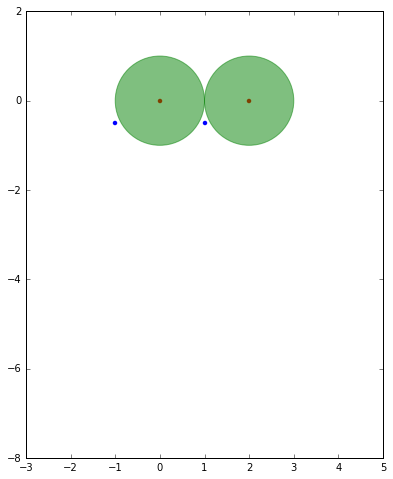

In [33]:

### Setting up a desired start and end camera position




min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(2,0,0)     # person B position
C_1 = toric.Vector3(-1,-0.5,0)  # Starting camera position is *outside* of PA_1
C_2 = toric.Vector3( 1,-0.5,0)    # Ending camera position

drawSetup()